## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [269]:
import os
import numpy as np
import pandas as pd
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score, confusion_matrix
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping

## Do some early processing of your metadata for easier model training:

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('../nih-chest-xray/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('../nih-chest-xray','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


Image Index                             Finding Labels  \
10073  00002611_010.png                                Atelectasis   
71460  00017611_007.png  Emphysema|Pleural_Thickening|Pneumothorax   
71028  00017515_006.png                                 No Finding   

       Follow-up #  Patient ID  Patient Age Patient Gender View Position  \
10073           10        2611           48              M            AP   
71460            7       17611           60              M            PA   
71028            6       17515           41              F            PA   

       OriginalImage[Width  Height]  OriginalImagePixelSpacing[x     y]  \
10073                 2500     2048                        0.168  0.168   
71460                 2678     2485                        0.143  0.143   
71028                 2992     2991                        0.143  0.143   

       Unnamed: 11                                               path  
10073          NaN  ../nih-chest-xray/images_002/images/00002611_0...  
71460          NaN  ../nih-chest-xray/images_008/images/00017611_0...  
71028          NaN  ../nih-chest-xray/images_008/images/00017515_0...

In [4]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Enumerate all labels
all_labels_raw = [item for sublist in all_xray_df['Finding Labels'].map(lambda x: x.split('|')).to_list() for item in sublist]
all_labels = np.unique(all_labels_raw)

# Create one-hot encodings for labels
for label in all_labels:
    all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1. if label in finding else 0.)

all_xray_df.head()

Image Index          Finding Labels  Follow-up #  Patient ID  \
0  00000001_000.png            Cardiomegaly            0           1   
1  00000001_001.png  Cardiomegaly|Emphysema            1           1   
2  00000001_002.png   Cardiomegaly|Effusion            2           1   
3  00000002_000.png              No Finding            0           2   
4  00000003_000.png                  Hernia            0           3   

   Patient Age Patient Gender View Position  OriginalImage[Width  Height]  \
0           58              M            PA                 2682     2749   
1           58              M            PA                 2894     2729   
2           58              M            PA                 2500     2048   
3           81              M            PA                 2500     2048   
4           81              F            PA                 2582     2991   

   OriginalImagePixelSpacing[x  ...  Emphysema  Fibrosis Hernia  Infiltration  \
0                        0.143  ...        0.0       0.0    0.0           0.0   
1                        0.143  ...        1.0       0.0    0.0           0.0   
2                        0.168  ...        0.0       0.0    0.0           0.0   
3                        0.171  ...        0.0       0.0    0.0           0.0   
4                        0.143  ...        0.0       0.0    1.0           0.0   

   Mass  No Finding  Nodule  Pleural_Thickening  Pneumonia  Pneumothorax  
0   0.0         0.0     0.0                 0.0        0.0           0.0  
1   0.0         0.0     0.0                 0.0        0.0           0.0  
2   0.0         0.0     0.0                 0.0        0.0           0.0  
3   0.0         1.0     0.0                 0.0        0.0           0.0  
4   0.0         0.0     0.0                 0.0        0.0           0.0  

[5 rows x 28 columns]

In [40]:
# Here we can create a new column called 'pneumonia_class' that will allow us to look at 
# images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].astype('str')

## Create your training and testing data:

In [30]:
def create_splits(df, val_size, rand_state, label_col_name):
    # Split first by preserving composition of pneumonia in the dataset
    train_data, val_data = train_test_split(df,
                                            test_size=val_size,
                                            random_state=rand_state,
                                            stratify=df[label_col_name])

    # Balance train_data to have 50:50 positive:negative composition
    train_pos = train_data[train_data[label_col_name] == 1]
    train_pos_n = train_pos.shape[0]
    train_neg_balanced = train_data.sample(train_pos_n, random_state=rand_state)
    train_data = pd.concat([train_pos, train_neg_balanced])
    
    
    return train_data, val_data # no redistribution to val_data: composition approx. reflects real-world (1.28% vs 1.4%)

In [42]:
train_data, val_data = create_splits(all_xray_df, 0.2, 42, 'Pneumonia')

## Perform some image augmentation on your data

In [169]:
def my_image_augmentation(is_val):
    # make custom function for background removal
    def remove_background(img):
        mask = img > (20 / 255.0)  # Convert threshold to 0-1 range
        
        return img * mask
    
    if is_val:
        my_idg = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=remove_background) # no augmentation for validation set
    else:
        my_idg = ImageDataGenerator(rescale=1./255,
                                    preprocessing_function=remove_background,
                                    horizontal_flip=True,
                                    height_shift_range=0.1,
                                    width_shift_range=0.1,
                                    rotation_range=10,
                                    shear_range=0.1,
                                    zoom_range=0.1)
    
    return my_idg


def make_train_gen(train_data):
    my_train_idg = my_image_augmentation(False)
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_data, 
                                                 directory=None, 
                                                 x_col='path',
                                                 y_col='pneumonia_class',
                                                 class_mode='binary',
                                                 classes=['0.0', '1.0'], # ensure labels mapping
                                                 target_size=(224,224),
                                                 batch_size=8)

    return train_gen


def make_val_gen(val_data):
    my_val_idg = my_image_augmentation(True)
    val_gen = my_val_idg.flow_from_dataframe(dataframe=val_data,
                                             directory=None, 
                                             x_col='path',
                                             y_col='pneumonia_class',
                                             class_mode='binary',
                                             classes=['0.0', '1.0'], # ensure labels mapping
                                             target_size=(224,224), 
                                             batch_size=128) 
    
    return val_gen

In [170]:
train_gen = make_train_gen(train_data)

Found 2290 validated image filenames belonging to 2 classes.


In [171]:
val_gen = make_val_gen(val_data)

Found 22424 validated image filenames belonging to 2 classes.


In [172]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.__next__()

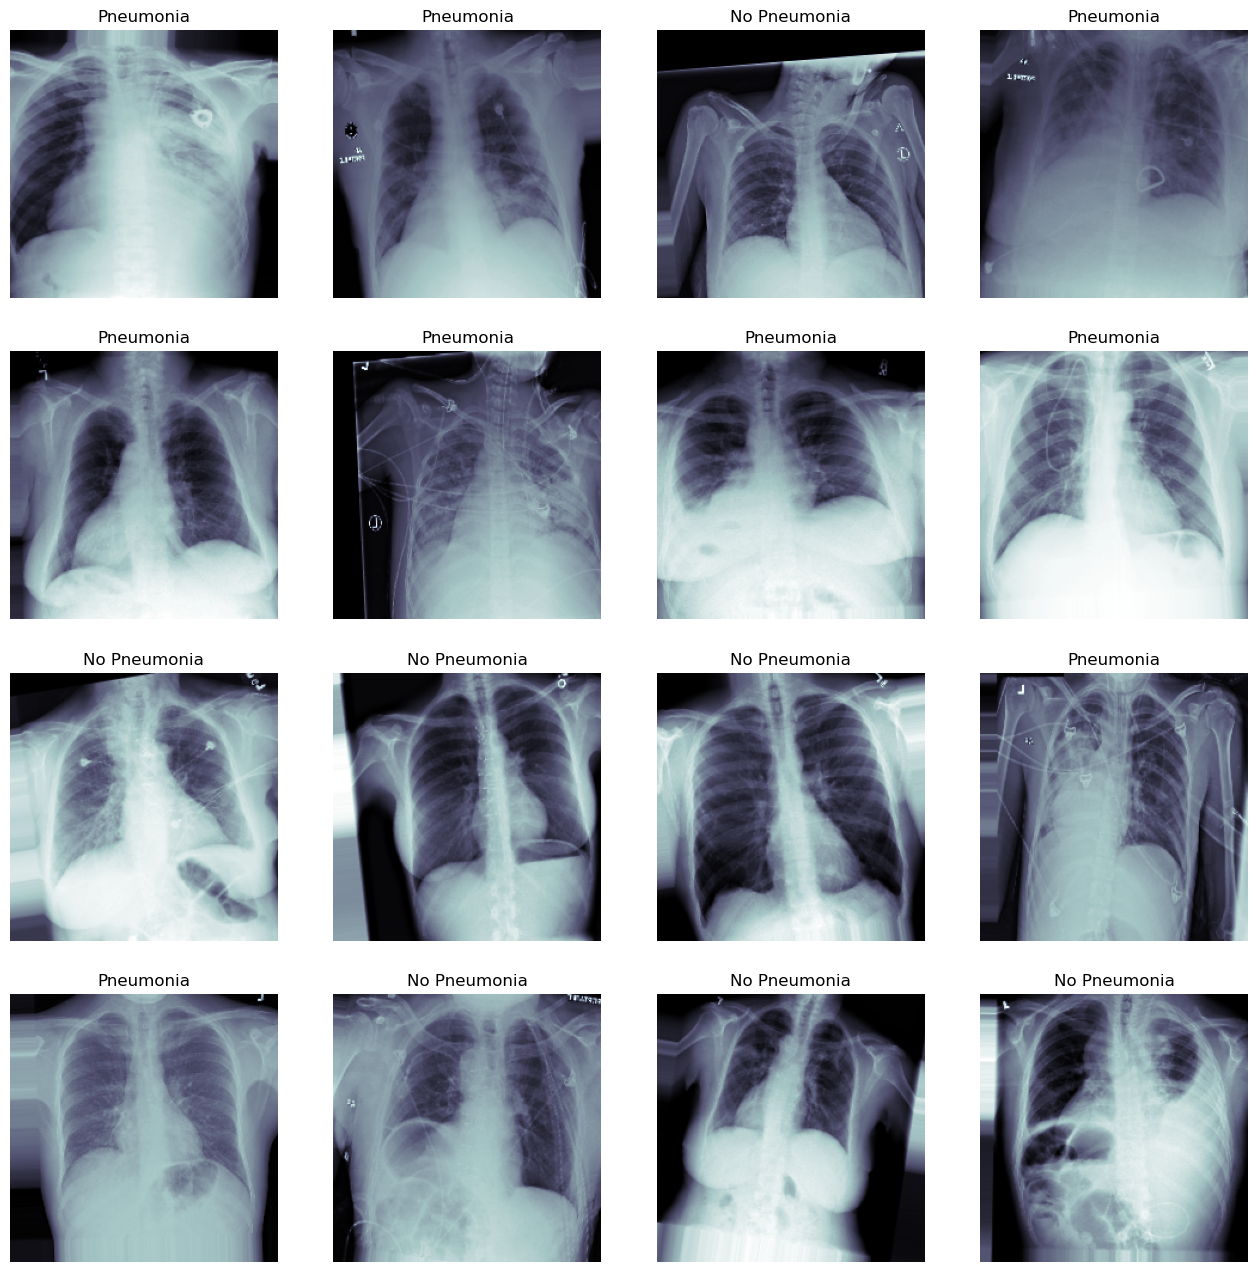

In [159]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [120]:
def load_pretrained_model(lay_of_interest):
    # Transfer the model up to the last convolutional layer
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

    # Set trainable layers
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    
    return vgg_model

In [160]:
vgg_model = load_pretrained_model('block5_pool')

In [161]:
vgg_model.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 2,359,808 (9.00 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [162]:
# check trainable layers
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_layer_7 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [163]:
def build_my_model(transfer_model, learning_rate):
    my_model = Sequential()
    my_model.add(transfer_model) # add the pretrained, transferred, model here

    # Add more layers: Flatten, 3x Dropout & Dense, Final Dense Layer
    my_model.add(Flatten())
    my_model.add(Dropout(0.1))
    my_model.add(Dense(256, activation='relu'))
    my_model.add(Dropout(0.1))
    my_model.add(Dense(128, activation='relu'))
    my_model.add(Dropout(0.1))
    my_model.add(Dense(64, activation='relu'))
    my_model.add(Dense(1, activation='sigmoid'))
    
    # Setting optimizer, loss function, and metrics
    my_model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    return my_model

In [173]:
# Make two model with different learning rate
my_model_1 = build_my_model(vgg_model, 1e-3)
my_model_2 = build_my_model(vgg_model, 1e-4)

In [174]:
my_model_1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_34 (Functional)      │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,178,689 (80.79 MB)

 Trainable params: 8,823,809 (33.66 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [175]:
my_model_2.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_34 (Functional)      │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,178,689 (80.79 MB)

 Trainable params: 8,823,809 (33.66 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [166]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training
weight_path_1="{}_my_model_1.best.weights.h5".format('xray_class')
weight_path_2="{}_my_model_2.best.weights.h5".format('xray_class')

checkpoint1 = ModelCheckpoint(weight_path_1, 
                              monitor='val_loss',
                              verbose=1, 
                              save_best_only=True, 
                              mode='min', 
                              save_weights_only=True)

checkpoint2 = ModelCheckpoint(weight_path_2, 
                              monitor='val_loss',
                              verbose=1, 
                              save_best_only=True, 
                              mode='min', 
                              save_weights_only=True)

early = EarlyStopping(monitor='val_loss',
                      mode='min',
                      patience=10)

### Start training! 

In [176]:
## train your model
history1 = my_model_1.fit(train_gen, 
                          validation_data=(valX, valY), 
                          epochs=15,
                          callbacks=[checkpoint1, early])

/opt/homebrew/Caskroom/miniforge/base/envs/pneumonia-detection/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - binary_accuracy: 0.5934 - loss: 0.6689
Epoch 1: val_loss did not improve from 0.69223
287/287 ━━━━━━━━━━━━━━━━━━━━ 131s 455ms/step - binary_accuracy: 0.5934 - loss: 0.6689 - val_binary_accuracy: 0.5469 - val_loss: 0.7263
Epoch 2/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - binary_accuracy: 0.6238 - loss: 0.6514
Epoch 2: val_loss improved from 0.69223 to 0.68209, saving model to xray_class_my_model_1.best.weights.h5
287/287 ━━━━━━━━━━━━━━━━━━━━ 130s 454ms/step - binary_accuracy: 0.6239 - loss: 0.6514 - val_binary_accuracy: 0.6172 - val_loss: 0.6821
Epoch 3/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/step - binary_accuracy: 0.6340 - loss: 0.6453
Epoch 3: val_loss improved from 0.68209 to 0.55510, saving model to xray_class_my_model_1.best.weights.h5
287/287 ━━━━━━━━━━━━━━━━━━━━ 131s 455ms/step - binary_accuracy: 0.6340 - loss: 0.6453 - val_binary_accuracy: 0.7188 - val_loss: 0.5551
Epoch 4/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/st

In [177]:
## train your model
history2 = my_model_2.fit(train_gen, 
                          validation_data=(valX, valY), 
                          epochs=15,
                          callbacks=[checkpoint2, early])

Epoch 1/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - binary_accuracy: 0.6188 - loss: 0.6582
Epoch 1: val_loss improved from inf to 0.72140, saving model to xray_class_my_model_2.best.weights.h5
287/287 ━━━━━━━━━━━━━━━━━━━━ 130s 451ms/step - binary_accuracy: 0.6189 - loss: 0.6581 - val_binary_accuracy: 0.5859 - val_loss: 0.7214
Epoch 2/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - binary_accuracy: 0.6630 - loss: 0.6144
Epoch 2: val_loss did not improve from 0.72140
287/287 ━━━━━━━━━━━━━━━━━━━━ 129s 450ms/step - binary_accuracy: 0.6630 - loss: 0.6144 - val_binary_accuracy: 0.5234 - val_loss: 0.7809
Epoch 3/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 429ms/step - binary_accuracy: 0.6883 - loss: 0.5972
Epoch 3: val_loss did not improve from 0.72140
287/287 ━━━━━━━━━━━━━━━━━━━━ 129s 450ms/step - binary_accuracy: 0.6883 - loss: 0.5972 - val_binary_accuracy: 0.4922 - val_loss: 0.7768
Epoch 4/15
287/287 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - binary_accuracy: 0.6865 - loss: 0.6026
Epoch 4: val_loss i

### Best Model: ```my_model_1```

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [219]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model = build_my_model(vgg_model, 1e-4)
my_model.load_weights(weight_path_1)
pred_Y = my_model.predict(val_gen, batch_size = 32, verbose=True)

/opt/homebrew/Caskroom/miniforge/base/envs/pneumonia-detection/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


176/176 ━━━━━━━━━━━━━━━━━━━━ 1108s 6s/step


In [235]:
my_model_2.load_weights(weight_path_2)
pred_Y_2 = my_model_2.predict(val_gen, batch_size = 32, verbose=True)

176/176 ━━━━━━━━━━━━━━━━━━━━ 1110s 6s/step


In [309]:
def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1)
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_title('ROC Curve')
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1)
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_title('Precision-Recall Curve')
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# function to calculate the F1 score
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)

def plot_history(history):
    N = len(history.history["loss"])
    # plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

### Plot Figures

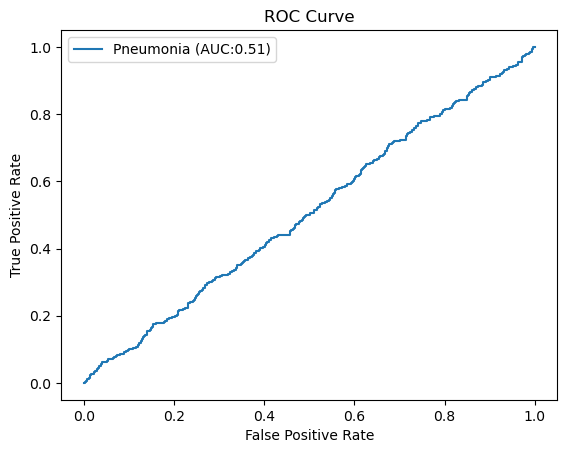

In [223]:
# ROC for my_model_1
plot_roc_curve(val_data['Pneumonia'], pred_Y)

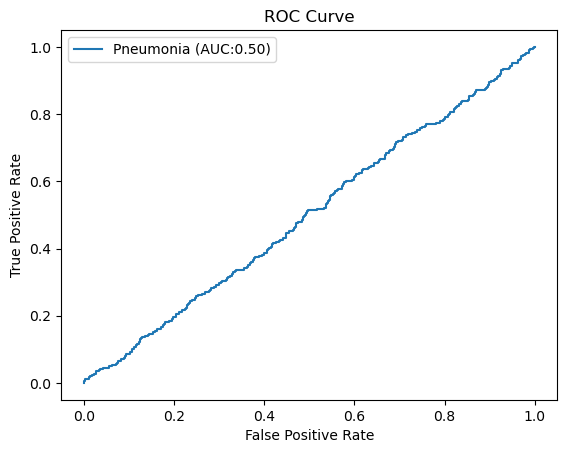

In [236]:
# ROC for my_model_2
plot_roc_curve(val_data['Pneumonia'], pred_Y_2)

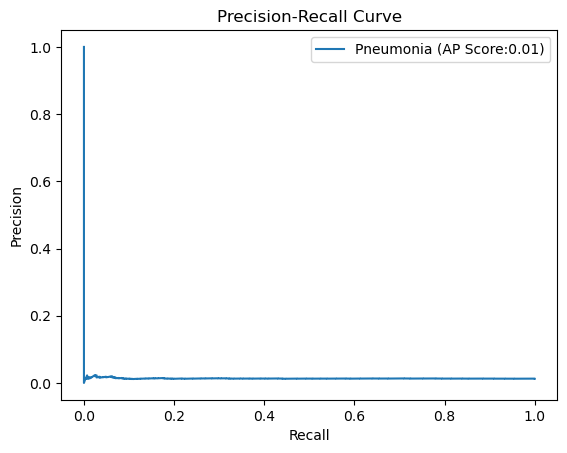

In [307]:
# Precision-Recall for my_model_1
plot_precision_recall_curve(val_data['Pneumonia'], pred_Y)

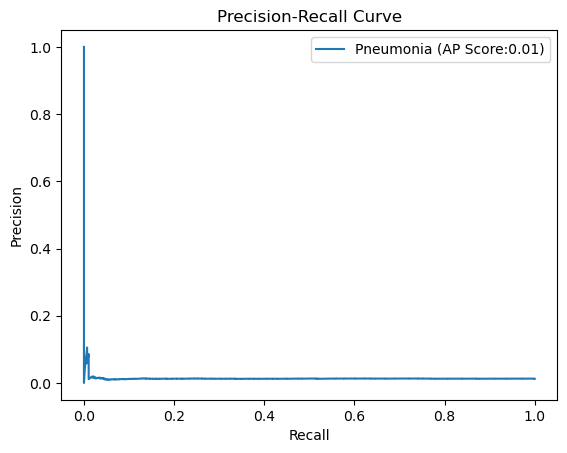

In [308]:
# Precision-Recall for my_model_2
plot_precision_recall_curve(val_data['Pneumonia'], pred_Y_2)

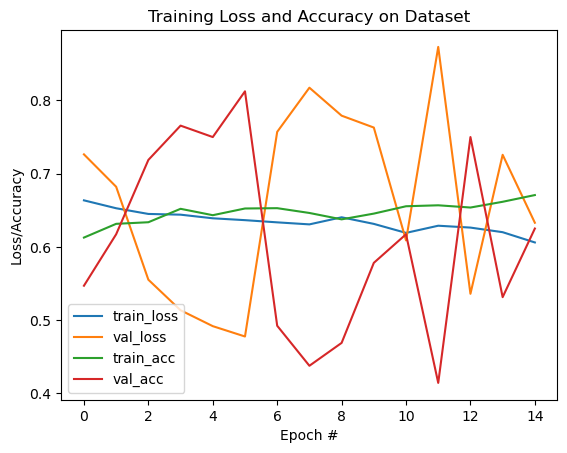

In [310]:
# Plot history of my_model_1 training
plot_history(history1)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [296]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
precision, recall, thresholds = precision_recall_curve(val_data['Pneumonia'], pred_Y)
f1_scores = [calc_f1(precision[i], recall[i]) for i in range(len(precision))]

/var/folders/fg/wwsz02rn0qn31sz3qslnnjm80000gn/T/ipykernel_33957/654575201.py:21: RuntimeWarning: invalid value encountered in scalar divide
  return 2*(prec*recall)/(prec+recall)


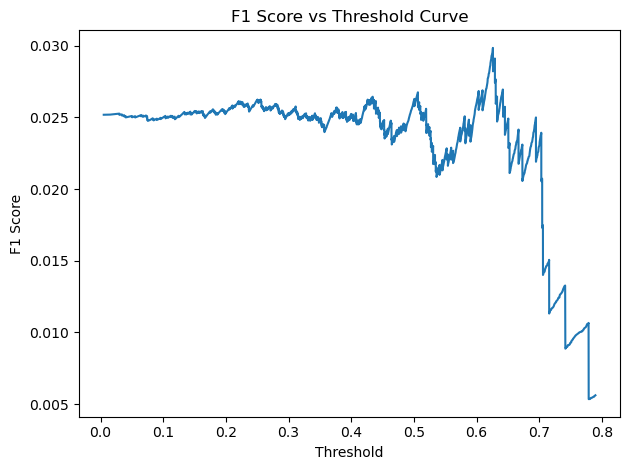

In [315]:
fig, c_ax = plt.subplots(1,1)
c_ax.plot(thresholds, f1_scores[:-1])
c_ax.set_title('F1 Score vs Threshold Curve')
c_ax.set_xlabel('Threshold')
c_ax.set_ylabel('F1 Score')
fig.tight_layout()

### Get the threshold with the highest F1 Score

In [321]:
idx = pd.Series(f1_scores).fillna(0).argmax()

In [322]:
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(f1_scores[idx]))

Precision is: 0.01956521739130435
Recall is: 0.06293706293706294
Threshold is: 0.6261586
F1 Score is: 0.02985074626865672


### Thus, the threshold value chosen is 62.94%.

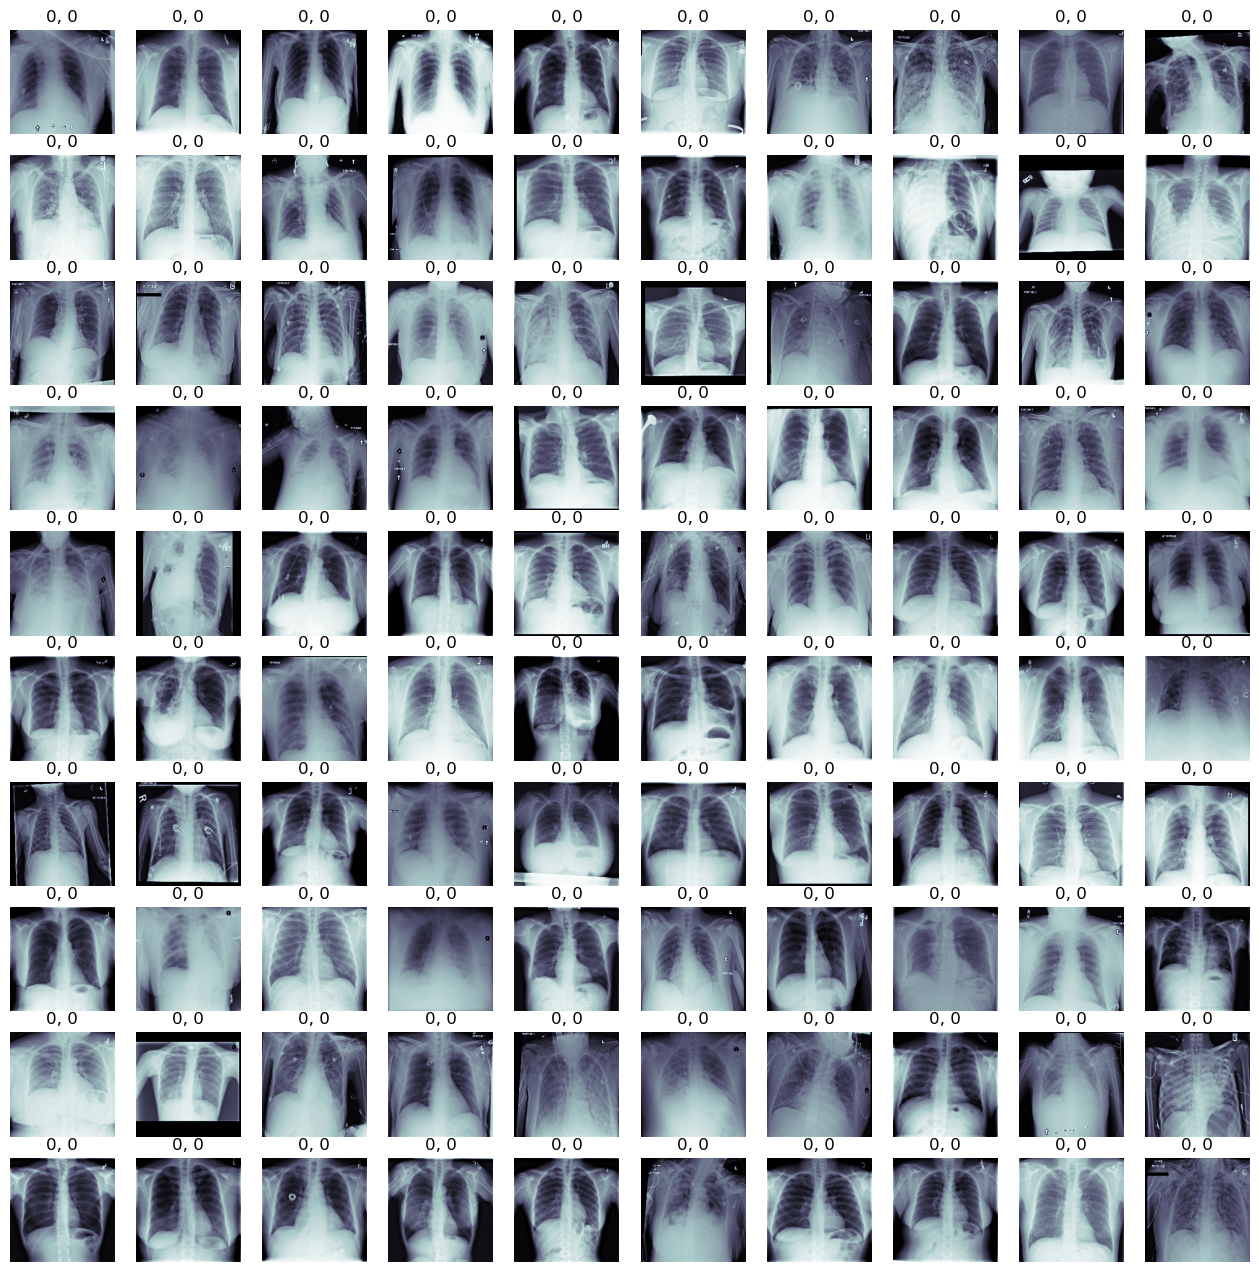

In [324]:
## Let's look at some examples of predicted v. true with our best model: 
fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], pred_Y[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > 0.6293706:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > 6293706: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [325]:
## Just save model architecture to a .json:

model_json = my_model_1.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)